In [3]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import itertools
import time
import torch
import pylab as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import memory as mem   
from feedforward import Feedforward

## Helper Functions

In [4]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [5]:
class DiscreteActionWrapper(gym.ActionWrapper):
    def __init__(self, env: gym.Env, bins = 5):
        """A wrapper for converting a 1D continuous actions into discrete ones.
        Args:
            env: The environment to apply the wrapper
            bins: number of discrete actions
        """
        assert isinstance(env.action_space, spaces.Box)
        super().__init__(env)
        self.bins = bins
        self.orig_action_space = env.action_space
        self.action_space = spaces.Discrete(self.bins)

    def action(self, action):
        """ discrete actions from low to high in 'bins'
        Args:
            action: The discrete action
        Returns:
            continuous action
        """
        return self.orig_action_space.low + action/(self.bins-1.0)*(self.orig_action_space.high-self.orig_action_space.low)  

# DQN

In [6]:
class QFunction(Feedforward):
    def __init__(self, observation_dim, action_dim, hidden_sizes=[100,100], 
                 learning_rate = 0.0002):
        super().__init__(input_size=observation_dim, hidden_sizes=hidden_sizes, 
                         output_size=action_dim)
        self.optimizer=torch.optim.Adam(self.parameters(), 
                                        lr=learning_rate, 
                                        eps=0.000001)
        self.loss = torch.nn.SmoothL1Loss() # MSELoss()
    
    def fit(self, observations, actions, targets):
        self.train() # put model in training mode
        self.optimizer.zero_grad()
        # Forward pass
        acts = torch.from_numpy(actions)
        pred = self.Q_value(torch.from_numpy(observations).float(), acts)
        # Compute Loss
        loss = self.loss(pred, torch.from_numpy(targets).float())
        
        # Backward pass
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def Q_value(self, observations, actions):
        return self.forward(observations).gather(1, actions[:,None])        
    
    def maxQ(self, observations):
        return np.max(self.predict(observations), axis=-1, keepdims=True)
        
    def greedyAction(self, observations):
        return np.argmax(self.predict(observations), axis=-1)

In [7]:
class DQNAgent(object):
    """
    Agent implementing Q-learning with NN function approximation.    
    """
    def __init__(self, observation_space, action_space, **userconfig):
        
        if not isinstance(observation_space, spaces.box.Box):
            raise UnsupportedSpace('Observation space {} incompatible ' \
                                   'with {}. (Require: Box)'.format(observation_space, self))
        if not isinstance(action_space, spaces.discrete.Discrete):
            raise UnsupportedSpace('Action space {} incompatible with {}.' \
                                   ' (Reqire Discrete.)'.format(action_space, self))
        
        self._observation_space = observation_space
        self._action_space = action_space
        self._action_n = action_space.n
        self._config = {
            "eps": 0.05,            # Epsilon in epsilon greedy policies                        
            "discount": 0.95,
            "buffer_size": int(1e5),
            "batch_size": 128,
            "learning_rate": 0.0002,
            "update_target_every": 20,
            "use_target_net":True
        }
        self._config.update(userconfig)        
        self._eps = self._config['eps']
        
        self.buffer = mem.Memory(max_size=self._config["buffer_size"])
                
        # Q Network
        self.Q = QFunction(observation_dim=self._observation_space.shape[0], 
                           action_dim=self._action_n,
                           learning_rate = self._config["learning_rate"])
        # Q Network
        self.Q_target = QFunction(observation_dim=self._observation_space.shape[0], 
                                  action_dim=self._action_n,
                                  learning_rate = 0)
        self._update_target_net()
        self.train_iter = 0
            
    def _update_target_net(self):        
        self.Q_target.load_state_dict(self.Q.state_dict())

    def act(self, observation, eps=None):
        if eps is None:
            eps = self._eps
        # epsilon greedy
        if np.random.random() > eps:
            action = self.Q.greedyAction(observation)
        else: 
            action = self._action_space.sample()        
        return action
    
    def store_transition(self, transition):
        self.buffer.add_transition(transition)
            
    def train(self, iter_fit=32):
        losses = []
        self.train_iter+=1
        if self._config["use_target_net"] and self.train_iter % self._config["update_target_every"] == 0:
            self._update_target_net()                
        for i in range(iter_fit):

            # sample from the replay buffer
            data=self.buffer.sample(batch=self._config['batch_size'])
            s = np.stack(data[:,0]) # s_t
            a = np.stack(data[:,1]) # a_t
            rew = np.stack(data[:,2])[:,None] # rew  (batchsize,1)
            s_prime = np.stack(data[:,3]) # s_t+1
            done = np.stack(data[:,4])[:,None] # done signal  (batchsize,1)
            
            if self._config["use_target_net"]:
                v_prime = self.Q_target.maxQ(s_prime)
            else:
                v_prime = self.Q.maxQ(s_prime)
            # target
            gamma=self._config['discount']                                                
            td_target = rew + gamma * (1.0-done) * v_prime
            
            # optimize the lsq objective
            fit_loss = self.Q.fit(s, a, td_target)
            
            losses.append(fit_loss)
                
        return losses

## Test in Env

In [16]:
#env_name = 'Pendulum-v1'
#env_name = 'CartPole-v0'
#env_name = 'MountainCar-v0'
env_name = 'LunarLander-v2'

env = gym.make(env_name)
if isinstance(env.action_space, spaces.Box):
    env = DiscreteActionWrapper(env,5)

ac_space = env.action_space
o_space = env.observation_space
print(ac_space)
print(o_space)
print(list(zip(env.observation_space.low, env.observation_space.high)))

Discrete(4)
Box([-90.        -90.         -5.         -5.         -3.1415927  -5.
  -0.         -0.       ], [90.        90.         5.         5.         3.1415927  5.
  1.         1.       ], (8,), float32)
[(-90.0, 90.0), (-90.0, 90.0), (-5.0, 5.0), (-5.0, 5.0), (-3.1415927, 3.1415927), (-5.0, 5.0), (-0.0, 1.0), (-0.0, 1.0)]


In [17]:
use_target = True
target_update = 20
learning_rate = 0.001
epsilon = 0.2
disc = 0.975
q_agent = DQNAgent(o_space, ac_space, discount=disc, eps=epsilon, 
                   use_target_net=use_target, update_target_every= target_update, learning_rate=learning_rate) #, discount=0.95, eps=0.2, use_target_net=use_target, update_target_every=target_update

In [18]:
ob,_info = env.reset()
q_agent.Q.predict(ob)

array([-0.03519771, -0.02129327, -0.1217073 ,  0.00539919], dtype=float32)

Running some episodes

In [19]:
stats = []
losses = []

In [20]:
max_episodes=3000
max_steps=1000
flag = False
for i in range(max_episodes):
    # print("Starting a new episode")    
    total_reward = 0
    ob, _info = env.reset()
    for t in range(max_steps):
        done = False        
        a = q_agent.act(ob)
        (ob_new, reward, done, trunc, _info) = env.step(a)
        total_reward+= reward
        q_agent.store_transition((ob, a, reward, ob_new, done))            
        ob=ob_new        
        if done: break    
    losses.extend(q_agent.train(32))
    stats.append([i,total_reward,t+1])    
    
    
    if ((i-1)%20==0):
        print("{}: Done after {} steps. Reward: {}".format(i, t+1, total_reward))
        if flag: print("     mean reward over last 20 episodes {}".format(sum(stats[(i-20):i][1])/20))
        flag = True

1: Done after 58 steps. Reward: -371.2864076088362
21: Done after 95 steps. Reward: -237.06732910687802
     mean reward over last 20 episodes -31.830910083711082
41: Done after 178 steps. Reward: -234.10175382694032
     mean reward over last 20 episodes -26.59343471174369
61: Done after 618 steps. Reward: 162.37663635025376
     mean reward over last 20 episodes 5.559614465491128
81: Done after 235 steps. Reward: -232.86085513740232
     mean reward over last 20 episodes 53.421639295869475
101: Done after 213 steps. Reward: 14.718555669200782
     mean reward over last 20 episodes 8.491796266364377
121: Done after 337 steps. Reward: -208.83791126873018
     mean reward over last 20 episodes 52.44315301817268
141: Done after 434 steps. Reward: 227.9695285813572
     mean reward over last 20 episodes 23.15138880909321
161: Done after 415 steps. Reward: 252.17842222566634
     mean reward over last 20 episodes 22.730351130744125
181: Done after 632 steps. Reward: 171.755429902037
     m

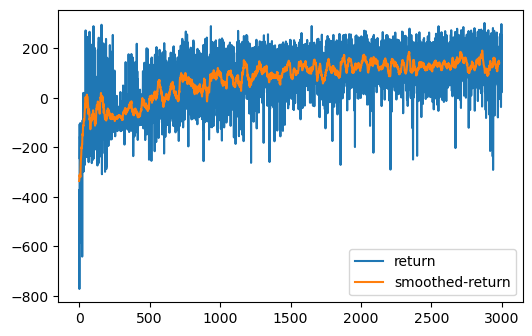

In [21]:
stats_np = np.asarray(stats)
losses_np = np.asarray(losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(stats_np[:,1], label="return")
plt.plot(running_mean(stats_np[:,1],20), label="smoothed-return")
plt.legend()

In [23]:
fig.savefig(f"DQN_{env_name}_episodes_{max_episodes}_steps_{max_steps}_lr_{learning_rate}_eps_{epsilon}_disc_{disc}_update_{target_update}_time.pdf")

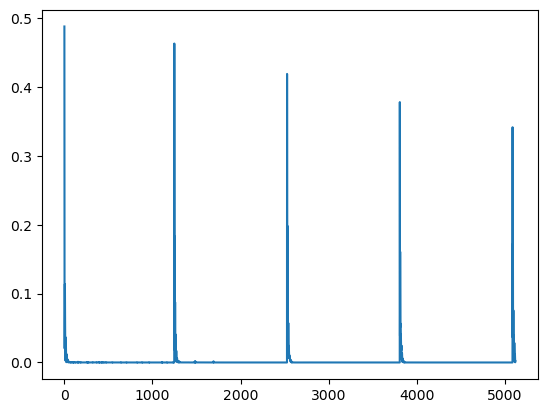

In [39]:
plt.figure()
plt.plot(losses_np)

In [89]:
fig.savefig(f"mountaincar_whatever.pdf")

In [40]:
q_agent.train(1024)

[0.0048649730160832405,
 0.005900684744119644,
 0.004837503656744957,
 0.0024711857549846172,
 0.0006055751582607627,
 0.0003561254998203367,
 0.001269420376047492,
 0.0024390071630477905,
 0.0030462953727692366,
 0.002287136623635888,
 0.0009683880489319563,
 0.00018818069656845182,
 0.00015741182141937315,
 0.0006595738814212382,
 0.001245888532139361,
 0.0013549472205340862,
 0.0011262637563049793,
 0.000569655152503401,
 0.00016512243018951267,
 5.6804226915119216e-05,
 0.00025559382629580796,
 0.0005106597673147917,
 0.0006307014846242964,
 0.0005667621735483408,
 0.0003714264021255076,
 0.00015183095820248127,
 7.054966408759356e-05,
 0.0001141515385825187,
 0.0002092128124786541,
 0.0002730387495830655,
 0.00023665580374654382,
 0.00020075158681720495,
 9.509547089692205e-05,
 5.1271945267217234e-05,
 6.207622209331021e-05,
 9.375181252835318e-05,
 0.00013150079757906497,
 0.0001240994461113587,
 0.00010863193165278062,
 5.982194124953821e-05,
 3.094376006629318e-05,
 1.99512833

In [55]:
q_agent.buffer.size

100000

## Evaluate (without exploration)

In [51]:
env_eval = gym.make(env_name, render_mode="human")
if isinstance(env.action_space, spaces.Box):
    env_eval = DiscreteActionWrapper(env_eval,5)

In [59]:
test_stats = []
episodes=20
max_steps=500
#env_ = env    # without rendering
env_ = env_eval # with rendering

for i in range(episodes):
    total_reward = 0
    ob, _info = env_.reset()
    for t in range(max_steps):
        done = False        
        a = q_agent.act(ob, eps=0.0)
        (ob_new, reward, done, trunc, _info) = env_.step(a)
        total_reward+= reward
        ob=ob_new        
        if done: break    
    test_stats.append([i,total_reward,t+1])     
    print("finished episode")   

finished episode


KeyboardInterrupt: 

In [15]:
test_stats_np = np.array(test_stats)
print(np.mean(test_stats_np[:,1]), "+-", np.std(test_stats_np[:,1]))

-165.33240475053958 +- 97.59344296304683


# Visualize

Visualization of Q function

In [2]:
def plot_Q_function(q_function, observations, plot_dim1=0, plot_dim2=2,
                    label_dim1="cos(angle)", label_dim2="angular velocity"):
    plt.rcParams.update({'font.size': 12})
    values =q_function.maxQ(observations)
    
    fig = plt.figure(figsize=[10,8])
    ax = fig.add_subplot()
    surf = ax.scatter (observations[:,plot_dim1], observations[:,plot_dim2],  c = values, cmap=cm.coolwarm)
    ax.set_xlabel(label_dim1)
    ax.set_ylabel(label_dim2)

    return fig

In [3]:
# Surface plot. However, less useful as it queries the Q function where it was not trained.
def plot_Q_function_gen_surface(q_function, input_dims, plot_dim1_range=(0,(-np.pi/2,np.pi/2)), plot_dim2_range=(1,(-0.2,0.2)),
                        label_dim1="angle", label_dim2="angular velocity"):
    plt.rcParams.update({'font.size': 12})
    xxs =np.linspace(*plot_dim1_range[1])
    yys =np.linspace(*plot_dim2_range[1])
    XX,YY=np.meshgrid(xxs,yys)
    num_points = XX.ravel().shape[0]
    dots = np.zeros((num_points,input_dims))
    dots[:,plot_dim1_range[0]] =  XX.ravel()
    dots[:,plot_dim2_range[0]] =  YY.ravel()  
    values =q_function.maxQ(dots).reshape(XX.shape)

    fig = plt.figure(figsize=[10,8])
    ax = plt.figure().add_subplot(projection='3d')
    surf = ax.plot_surface(XX, YY, values, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.view_init(elev=20, azim=45, roll=0)
    ax.set_xlabel(label_dim1)
    ax.set_ylabel(label_dim2)
    ax.set_zlabel('value')
    # plt.colorbar(cmap=cm.coolwarm)
    return fig

NameError: name 'np' is not defined

## Pendulum Env

Observation space:

0 cos(angle)

1 sin(angle)

2 angular velocity

In [18]:
data = q_agent.buffer.get_all_transitions()
data = np.vstack(data[:,0])

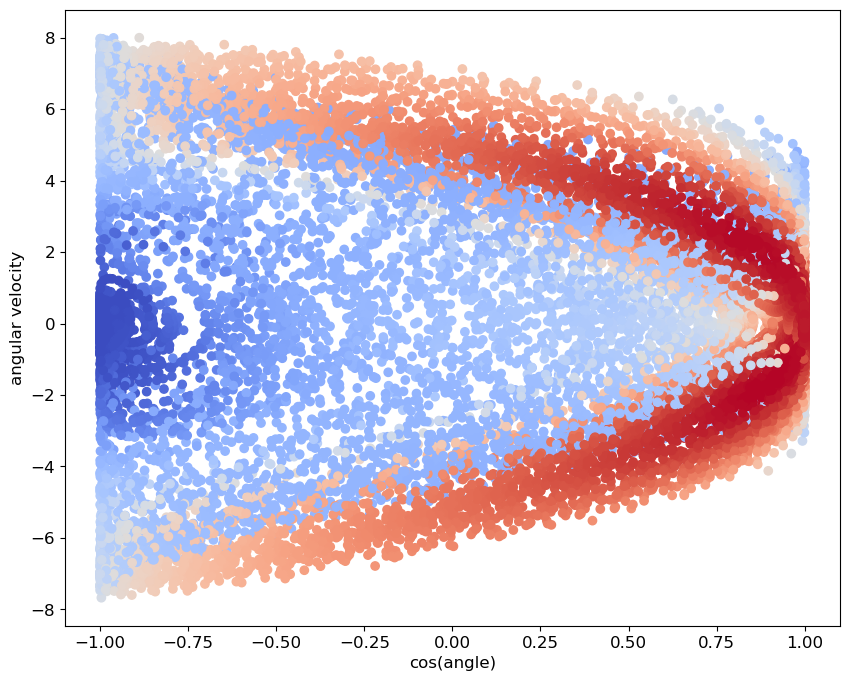

In [19]:
figQ = plot_Q_function(q_agent.Q, data, plot_dim1=0, plot_dim2=2)

## Cartpole Env

Observation space:
 
0       Cart Position             -4.8                    4.8

1       Cart Velocity             -Inf                    Inf

2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)

3       Pole Angular Velocity     -Inf                    Inf

In [ ]:
data = q_agent.buffer.get_all_transitions()
data = np.vstack(data[:,0])

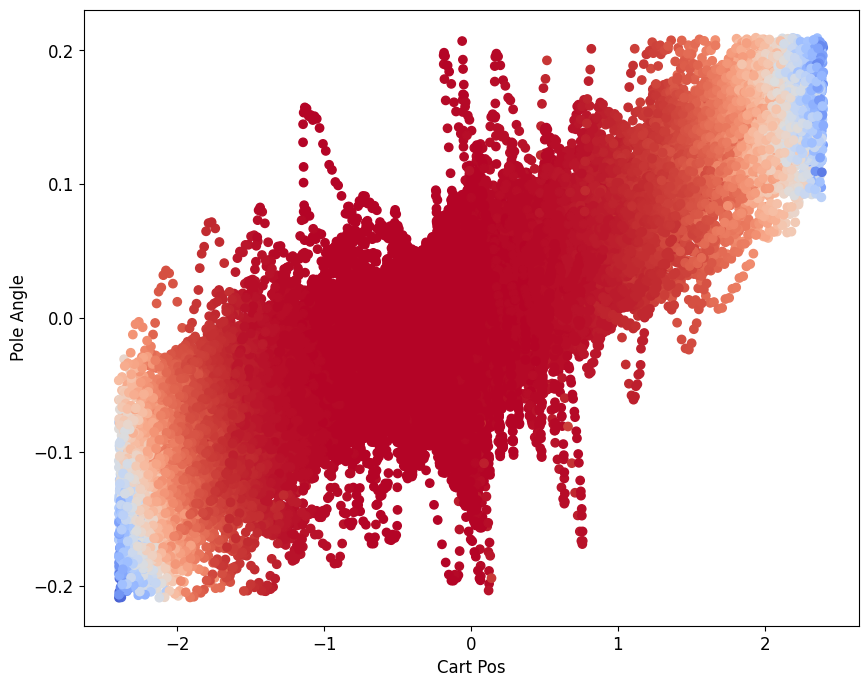

In [52]:
figQ = plot_Q_function(q_agent.Q, data, plot_dim1=0, plot_dim2=2, 
                       label_dim1="Cart Pos", label_dim2="Pole Angle")

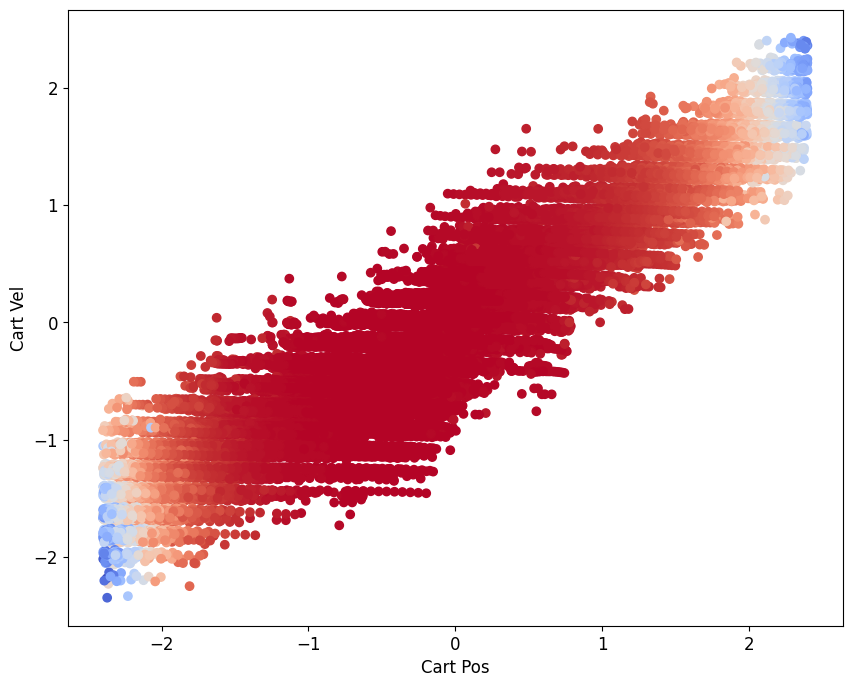

In [53]:
figQ = plot_Q_function(q_agent.Q, data, plot_dim1=0, plot_dim2=1, 
                       label_dim1="Cart Pos", label_dim2="Cart Vel")

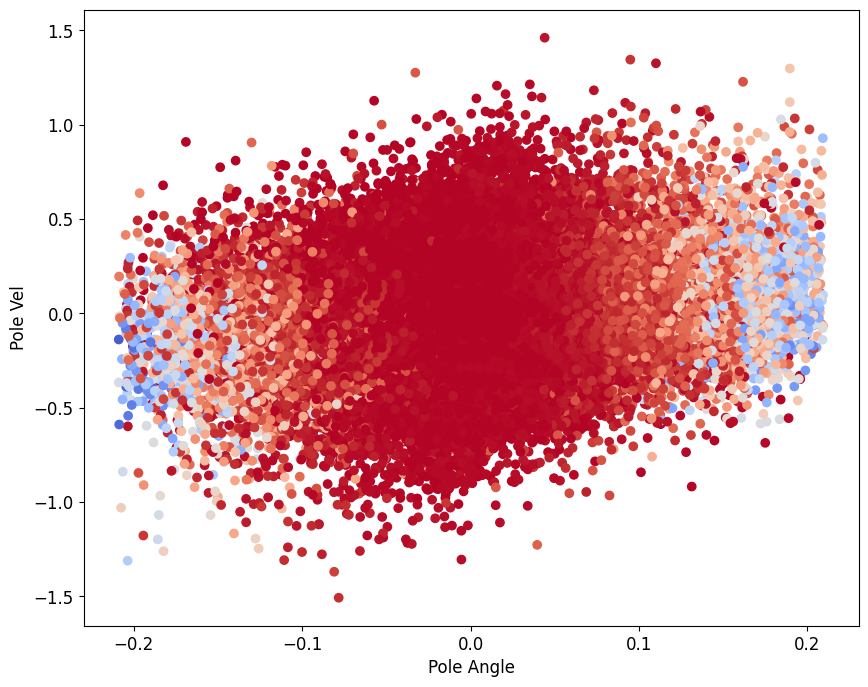

In [54]:
figQ = plot_Q_function(q_agent.Q, data, plot_dim1=2, plot_dim2=3, 
                       label_dim1="Pole Angle", label_dim2="Pole Vel")

In [20]:
%matplotlib notebook

In [ ]:
# env_name = 'Acrobot-v1'
# env_name = 'MountainCar-v0'
# env_name = 'LunarLander-v2'